# Review Microbit Data
Now that we have programmed the microbit to grab data from the microbit's sensors (accelerometer and magnetometer), we can let it stream data over the serial port. The python script (python_save.py) reads this data stream and pipes it to disk. 

This notebook picks up the binary data from a file, parses the accelerometer and magnetometer data and plots it to see if anything interesting happened. 

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import struct
import re

np_f = npt.NDArray[np.float_]

In [2]:
# Define some useful helper functions
def magnitude(vector: np_f) -> np_f:
    # Calculate magnitude from 3-vector
    magnitude = np.sqrt((vector**2).sum(axis=1))
    return magnitude

The timestamp denoting the time that the Python script sees its first valid data packet is included in the data filename. This can be extracted using regex. Note, the datetime is in isoformat, with the exception that the colons (:) have been replaced by underscores (_) to ensure that the filename is a valid Windows path. 

In [3]:
# Define timestamp format
timestamp_re = r'\d{4}-\d\d-\d\dT\d\d_\d\d_\d\d.\d+\+\d\d_\d\d'
plt_fmt = mdates.DateFormatter('%H:%M')

In [4]:
# Define filename and extract timestamp
filename = r'./2024-04-25T16_23_12.077644+01_00_Microbit.bin'
timestamp_str = re.search(timestamp_re, filename).group().replace('_', ':')
timestamp_start = dt.datetime.fromisoformat(timestamp_str)

# Read all data from file
with open(filename, 'rb') as fi:
    buff = fi.read()

Now that the data has been read in as a byte array, we can unpack the data into the correct data type. Note, that we know that the format that the data has been packaged into, so we can simply undo this process. Each data packet is formatted as following:

| Data | Data Format |
|------|-------------|
| Timestamp (elapsed seconds) | f64 / double / d |
| Number of averages | u8 / unsigned char / B |
| Acceleration_x (mg) | f64 / double / d |
| Acceleration_x (mg) | f64 / double / d |
| Acceleration_x (mg) | f64 / double / d |
| Magnetic_x (nT) | f64 / double / d |
| Magnetic_y (nT) | f64 / double / d |
| Magnetic_z (nT) | f64 / double / d |

Using the struct module, we can define the format of the packet as '>dB6d', noting that the data is send in big-endian format. We can numpy to read in the data in the correct format into numpy arrays. 

In [5]:
# Define packet format and work out how many readings we have
reading_fmt = '>dB6d'
reading_size = struct.calcsize(reading_fmt)
num_readings = len(buff)//reading_size

# Read results into arrays given the known format of the data
secs = np.ndarray(shape=(num_readings,), dtype='>d', buffer=buff, offset=0, strides=(reading_size,))
aves = np.ndarray((num_readings,), '>B', buff, struct.calcsize('>d'), (reading_size,))
acceleration = np.ndarray((num_readings,), '>3d', buff, struct.calcsize('>dB'), (reading_size,))
magnetic = np.ndarray((num_readings,), '>3d', buff, struct.calcsize('>dB3d'), (reading_size,))

# Convert elapsed seconds into a timestamp
timestamp = np.array([dt.timedelta(seconds=sec) + timestamp_start
                      for sec in secs])

# Convert measurements into magnitudes
magnetic_strength = magnitude(magnetic)
accel_strength = magnitude(acceleration)

We can now look at the magnitude of the data over time for 27<sup>th</sup> of April.

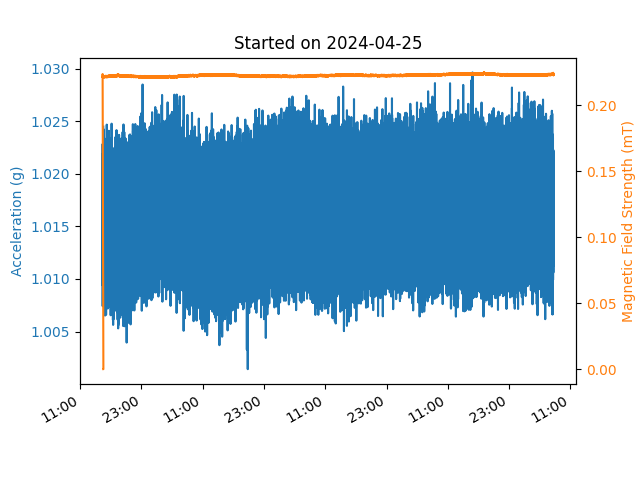

In [6]:
%matplotlib widget
# Create mask to select only data from 27th
desired_day = dt.date(2024, 4, 27)
mask = [ts.date() == desired_day for ts in timestamp]
mask = np.ones(len(timestamp), dtype=bool)

fig1, ax1a = plt.subplots()
ax1a.plot(timestamp[mask], 1e-3*accel_strength[mask], color='C0')
ax1a.set_ylabel('Acceleration (g)', color='C0')
ax1a.tick_params(axis='y', labelcolor='C0')
ax1a.xaxis.set_major_formatter(plt_fmt)

ax1b = ax1a.twinx()
ax1b.plot(timestamp[mask], magnetic_strength[mask]/1e6, color='C1')
ax1b.set_ylabel('Magnetic Field Strength (mT)', color='C1')
ax1b.tick_params(axis='y', labelcolor='C1')
title = f'Started on {timestamp[mask][0].strftime('%Y-%m-%d')}'
ax1b.set_title(title)
fig1.autofmt_xdate()

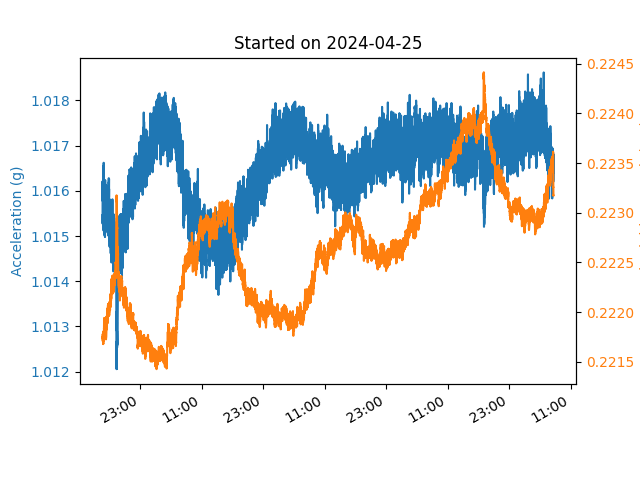

In [7]:
# Let tidy up the data a little bit via moving average filtering and removing outliers
def moving_average(data: np_f, windowlength: int) -> np_f:
    '''Performs moving average filtering on data.

    Inputs:
        data (numpy array):
            Array containing timeseries data (1d array)
        windowlength (int):
            Number of points to average over (int)

    Returns:
        averaged (numpy array):
            Smoothed data (same length as data)
    '''
    wndo = np.ones(windowlength)/windowlength

    return np.convolve(data, wndo, 'same')


win_length = 100
averaged_mag = moving_average(magnetic_strength, windowlength=win_length)
averaged_acc = moving_average(accel_strength, windowlength=win_length)

ave_slice = slice(win_length//2+1, -win_length//2-1)
ave_slice = slice(1000, -win_length//2)

fig2, ax2a = plt.subplots()
ax2a.plot(timestamp[ave_slice], 1e-3*averaged_acc[ave_slice], color='C0')
ax2a.set_ylabel('Acceleration (g)', color='C0')
ax2a.tick_params(axis='y', labelcolor='C0')
ax2a.xaxis.set_major_formatter(plt_fmt)

ax2b = ax2a.twinx()
ax2b.plot(timestamp[ave_slice], averaged_mag[ave_slice]/1e6, color='C1')
ax2b.set_ylabel('Magnetic Field Strength (mT)', color='C1')
ax2b.tick_params(axis='y', labelcolor='C1')
title = f'Started on {timestamp[mask][0].strftime('%Y-%m-%d')}'
ax2b.set_title(title)
fig2.autofmt_xdate()

We can see some variation in both the magnetic field strength and the measured acceleration. Looking at the acceleration data, it is very strange to see that the local acceleration is changing over a 24-hour period over the weekend! This makes me wonder whether temperature is affecting the sensors. 

The best way to find out is to look to see whether it is possible to measure the temperature. Luckily, it appears that there is an onboard temperature sensor, within the [nRF52 core](https://tech.microbit.org/hardware/#temperature-sensing). 